#Library

In [ ]:
import os
import cv2
import pdb
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input

#Prepare dataset

##donwload

In [ ]:
!wget http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip

--2022-12-24 12:36:36--  http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip
Resolving adas.cvc.uab.es (adas.cvc.uab.es)... 158.109.8.54
Connecting to adas.cvc.uab.es (adas.cvc.uab.es)|158.109.8.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114312538 (109M) [application/zip]
Saving to: ‘KITTI_SEMANTIC.zip.1’

KITTI_SEMANTIC.zip. 100%[===================>] 109.02M  6.82MB/s    in 18s     

2022-12-24 12:36:54 (6.11 MB/s) - ‘KITTI_SEMANTIC.zip.1’ saved [114312538/114312538]



In [ ]:
!unzip -q "/content/KITTI_SEMANTIC.zip"

replace KITTI_SEMANTIC/Validation_07/GT/000294.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##define generator

In [ ]:
kitti_classes = {
    'Building':   [128, 0,   0],
    'Vegetation': [128, 128, 0],
    'Sky':        [128, 128, 128],
    'Car':        [64,  0,   128],
    'Sign':       [192, 128, 128],
    'Road':       [128, 64,  128],
    'Pedestrian': [64,  64,  0],
    'Fence':      [64,  64,  128],
    'Pole':       [192, 192, 128],
    'Sidewalk':   [0,   0,   192],
    'Cyclist':    [0,   128, 192],
}

class DataGenerator(keras.utils.Sequence):
    def __init__(self, path, batch_size=1, shuffle=True, subset='train'):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.subset = subset

        rgb_path = path + '/RGB/'
        gt_path = path + '/GT/'

        self.images = []
        self.segments = []
        for name in np.sort(os.listdir(rgb_path)):
            rgb_name = rgb_path + name
            gt_name = gt_path + name

            rgb = cv2.imread(rgb_name)
            rgb = cv2.resize(rgb, (128,128))
            gt = cv2.imread(gt_name)
            gt = cv2.resize(gt, (128,128))
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

            labels = np.zeros(gt.shape[:2])
            for i, (key, value) in enumerate(kitti_classes.items()):
              labels[np.sum(gt == value, axis=2) == 3] = i+1

            mask = labels == 0
            labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
            labels[mask==1, :] = 0

            self.images.append(rgb)
            self.segments.append(labels)

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))


    def __getitem__(self, index):
        image = self.images[index]
        segment = self.segments[index]

        d0 = np.mod(image.shape[0], 16)
        d1 = np.mod(image.shape[1], 16)

        image = image[d0:, d1:, :]
        segment = segment[d0:, d1:, :]

        if self.subset == 'train':
            if np.random.uniform() > 0.5:
                image = cv2.flip(image, 1)
                segment = cv2.flip(segment, 1)
        return np.expand_dims(image, axis=0), np.expand_dims(segment, axis=0)

    # Updates indices after each epoch
    def on_epoch_end(self):
        self.indices = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

train_generator = DataGenerator('/content/KITTI_SEMANTIC/Training_00')
valid_generator = DataGenerator('/content/KITTI_SEMANTIC/Validation_07', shuffle=False, subset='valid')

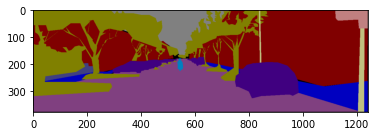

In [ ]:
gt = cv2.imread('/content/KITTI_SEMANTIC/Training_00/GT/000000.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(gt)

In [ ]:
labels = np.zeros(gt.shape[:2])
for i, (key, value) in enumerate(kitti_classes.items()):
  labels[np.sum(gt == value, axis=2) == 3] = i+1

mask = labels == 0
labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
labels[mask==1, :] = 0

In [ ]:
np.sum(labels == 4) / np.sum(labels >= 0)

0.0

#Define Architecture

<font color='red'>**Questions**</font>

1-what's the effect of padding is equal same? What's another value for padding?

Normally, after each convolutional layer, the width of the representation is reduced by one unit less than the width of the kernel in each layer. In this case, padding = 'valid'. (it's the default case)
 
But when we set the padding = 'same', that is, we add Wk - 1 zero padding so 
that the output dimensions are equal to the input dimensions. <br><br>


2- explain the affection of activation function.

A neural network without an activation function is just a linear regression model, that cannot learn non-linear functions. The activation function does the non-linear transformation to the input, making it capable to learn and perform more complex tasks.<br><br>


3- explain the affection of using kernel_initializer in layers.

Kernel initializers are used to statistically initialise the weights in the model. This will generate the weights and distribute them, it can be used as the starting weights.<br>
he_normal initializer takes samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.

In [ ]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

<font color='red'>**Questions**</font>

4- explain what's the difference between Conv2DTranspose and Conv2D.

Conv2D is used to detect features. as we saw in the slides, we use it in the encoder part of an autoencoder model. With this layer, spatial dimensions can be reduced along the network. (with stride more than 1) <br><br>
Conv2DTranspose is used for creating features, we use it in the decoder part of an autoencoder model for constructing an image. with the transposed convolution we can increase spatial dimensions along the network (with stride less than 1), such that the output dimensions are larger than the input dimension.

These are typically used for deconvolution and upsampling. it mainly used in semantic segmentation networks.

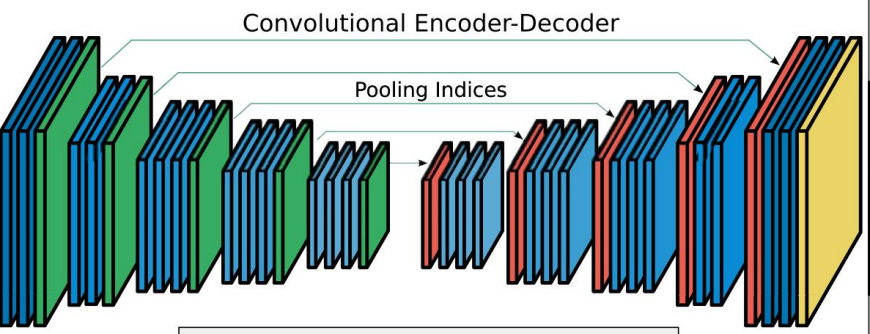


In [ ]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)

   return x

<font color='red'>**Questions**</font>

5- explain downsample_block, double_conv_block and upsample_block functions.


**downsample_block:**

it adds two convolutional layers to the model, one of the outputs of the function is prepared so far, and then it adds a maxpolling layer. In fact, the main purpose of this layer is to subsample the input image in order to reduce the computational load, memory and the number of parameters (to reduce the risk of overfitting).
it also uses dropout layer for reularization.

**double_conv_block:**

This function creates two convolutional layers with the number of filters = n_filters and padding = same, and activation function = relu and the initial kernel of he_normal. It gets the input of the first layer in its argument, and the input of the second layer is created by the first layer. Then it returns the second layer as the output.

**upsample_block:**

This function first creates a conv2dTranspose layer, which increases the dimensions of the input. Then, with the concatinate layer, it combines the features we had in the output of a few previous layer (the conv2d layer that had output_size equals to output_size of this conv2dTranspose layer), then it uses a dropout layer to regularize and prevent overfitting. Finally, by calling the double_conv_block function, it puts two convolutional layers at the end of layers. This increases the quality of the inputs.

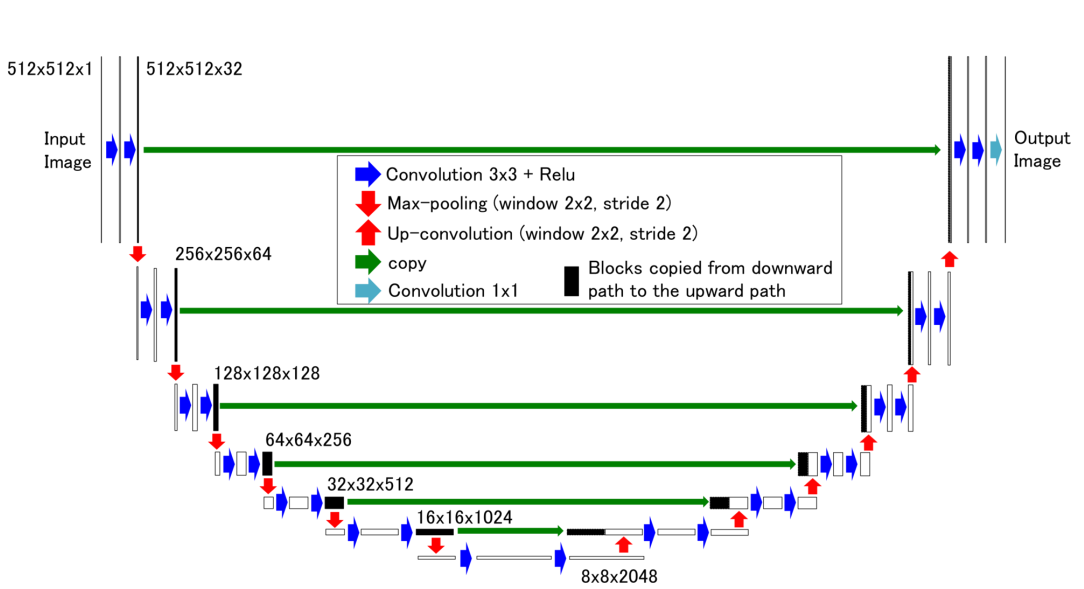

In [ ]:
def build_unet_model(): 
   inputs = layers.Input(shape=(128,128,3))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)
   bottleneck = double_conv_block(p4, 1024)
   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)
   outputs = layers.Conv2D(11, 1, padding="valid", activation = "softmax")(u9)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

<font color='red'>**Attention**</font>

* Before seeing the result of the following cell, try to compute the parameters of each layer, that's useful!

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

#Train Model

<font color='red'>**Questions**</font>

6- why use an optimizer in learning?

Optimizers are used to adjust the parameters for a model. An optimizer must be used when training a neural network model. The purpose of an optimizer is to adjust model weights to minimze the loss function. The loss function is used to measure how well the model is performing.<br><br>

7- why use compile function?

Compiling a model is required to finalise the model and make it completely ready to use. For compilation, we need to specify an optimizer and a loss function.<br><br>


8- why are we select categorical_crossentropy in the loss of function?

when we have a classification task, we use crossentropy as the loss function.
categorical_crossentropy used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. 

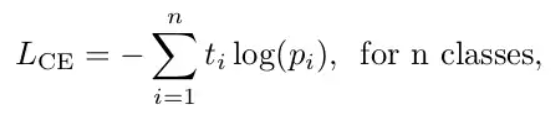


In [ ]:
unet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_generator.segments[0].shape

(128, 128, 11)

In [ ]:
unet_model.outputs[0].shape

TensorShape([None, 128, 128, 11])

<font color='red'>**Questions**</font>

9 - explain earlystopping function

Early stopping is an optimization technique used to reduce overfitting without compromising on model accuracy. The main idea behind early stopping is to stop training before a model starts to overfit.

we can check the val_loss in each epoch. we know it decrease at the first of training. but after some epochs, model starts overfitting on the training set. so we can stop the training when from the epoch that val_loss does'nt decrease anymore. we call it earlystopping technique.<br><br>

10 - explain different between fit and compile functions in Keras 

First, we want to build model, and decide a model architecture, the number of hidden layers and activation functions, etc.

by model.compile, we finalise the model and make it completely ready to use. in this function we  specify an optimizer and a loss function.

after that, we call model.fit to train the model on the training set, with the given inputs (and corresponding training labels)<br><br>

11- explain the difference between batch and epoch

**epoch:** 

One Epoch is when an entire dataset is passed forward and backward through the neural network only once. so epochs is the max number of iterations we want to do this work.

you can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples

**batch:** 

we can’t pass the entire dataset into the neural net at once. So, we divide dataset into Number of Batches or sets or parts.

The batch size is a number of samples processed before the model is updated.
The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.<br><br>

They are both integer values and they are both hyperparameters for the learning algorithm.

In [ ]:

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

# Train model on dataset
history = unet_model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
100/100 [==============================] - 14s 75ms/step - loss: 78.8504 - accuracy: 0.1860 - val_loss: 36.2186 - val_accuracy: 0.3131
Epoch 2/100
100/100 [==============================] - 6s 64ms/step - loss: 42.4515 - accuracy: 0.2382 - val_loss: 26.5311 - val_accuracy: 0.3218
Epoch 3/100
100/100 [==============================] - 6s 59ms/step - loss: 31.0965 - accuracy: 0.2505 - val_loss: 22.0838 - val_accuracy: 0.3257
Epoch 4/100
100/100 [==============================] - 6s 58ms/step - loss: 23.8444 - accuracy: 0.2599 - val_loss: 17.9379 - val_accuracy: 0.3322
Epoch 5/100
100/100 [==============================] - 6s 57ms/step - loss: 18.9398 - accuracy: 0.2699 - val_loss: 14.5791 - val_accuracy: 0.3359
Epoch 6/100
100/100 [==============================] - 6s 57ms/step - loss: 15.3541 - accuracy: 0.2757 - val_loss: 11.7276 - val_accuracy: 0.3416
Epoch 7/100
100/100 [==============================] - 6s 58ms/step - loss: 12.7323 - accuracy: 0.2747 - val_loss: 8.9744 -

#Inference

In [ ]:
def deisplay_prediction(x,y_prediction):
  color_dict = {0:(255,0,0),1:(0,0,255),2:(0,255,0),3:(128,128,128),4:(128,0,0),5:(0,128,0),6:(0,0,128),7:(255,255,255),8:(0,0,0),9:(128,255,128),10:(255,128,255)}
  fig = plt.figure()    
  plt.subplot(1, 2, 1)  
  plt.title("original image")  
  plt.imshow(x)
  prediction_image = x
  flag = 0
  for row in range(y_prediction[0].shape[0]):
    for column in range(y_prediction[0].shape[1]):
      prediction_image[row][column][:] = color_dict[np.argmax(y_prediction[0,row,column,:])]
  plt.subplot(1, 2, 2)
  plt.title("segmented image")
  plt.imshow(prediction_image)
  plt.show()
  # return prediction_image    

      

1/1 [==============================] - 0s 261ms/step


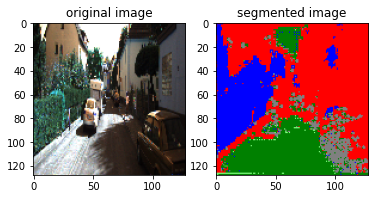

In [ ]:
X, Y_true = valid_generator.__getitem__(20)
deisplay_prediction(X[0],unet_model.predict(X))
